# Microsoft Stock Time Series Analysis

In [196]:
# Importing Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [197]:
# Reading in the Data

df = pd.read_csv('Data/MSFT.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [198]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700
2023-12-20,375.000000,376.029999,370.529999,370.619995,370.619995,26316700
2023-12-21,372.559998,374.410004,370.040009,373.540009,373.540009,17708000
2023-12-22,373.679993,375.179993,372.709991,374.579987,374.579987,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,374.660004,12673100


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9524 entries, 1986-03-13 to 2023-12-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9524 non-null   float64
 1   High       9524 non-null   float64
 2   Low        9524 non-null   float64
 3   Close      9524 non-null   float64
 4   Adj Close  9524 non-null   float64
 5   Volume     9524 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 520.8 KB


In [200]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9524.000000,9524.000000,9524.000000,9524.000000,9524.000000,9.524000e+03
mean,52.820706,53.383050,52.249194,52.836106,47.328041,5.733974e+07
std,78.772359,79.565262,77.951983,78.800088,78.820530,3.815727e+07
min,0.088542,0.092014,0.088542,0.090278,0.055969,2.304000e+06
25%,5.523438,5.615967,5.446045,5.529297,3.427964,3.300222e+07
50%,27.200001,27.469999,26.969999,27.219999,19.103065,5.049085e+07
75%,45.437500,46.060626,44.870001,45.471562,35.911209,7.123635e+07
max,383.760010,384.299988,378.160004,382.700012,382.700012,1.031789e+09


In [201]:
# Changing dataframe into index with closing price

df_close = df['Close']
df_close.head()

Date
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
Name: Close, dtype: float64

## Data Visualization

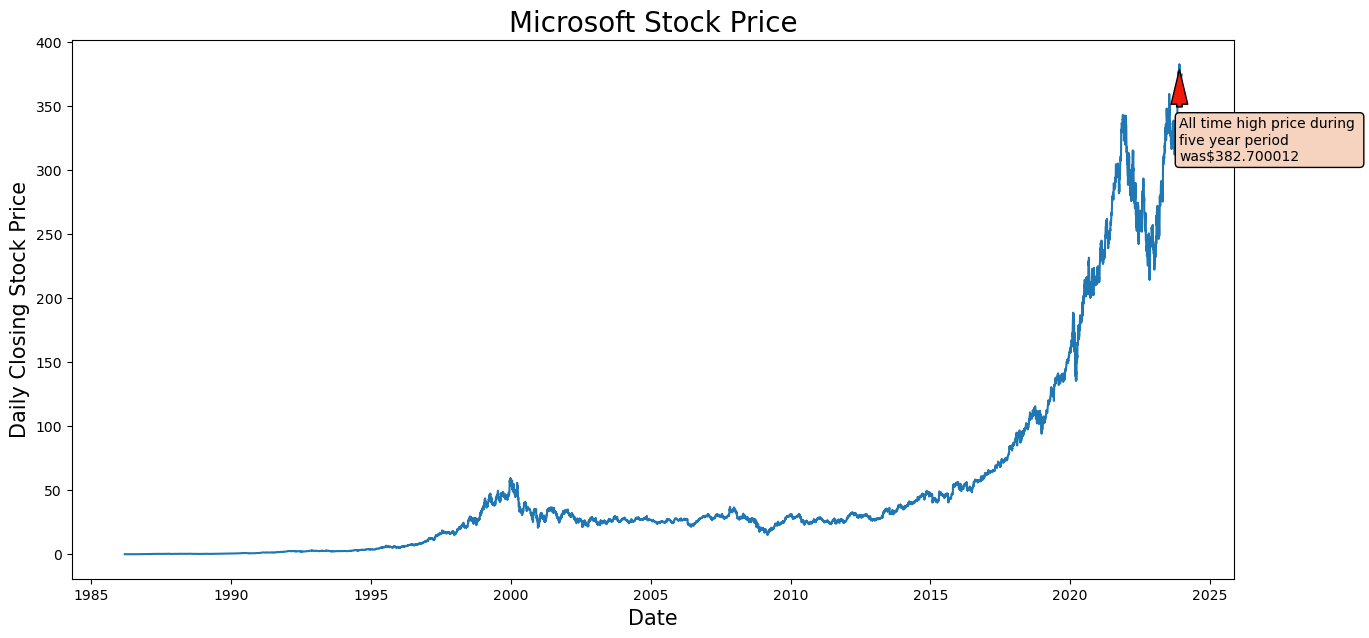

In [188]:
high = df['Close'].max()
high_date = df['Close'].idxmax()

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df['Close'])

ax.set_title("Microsoft Stock Price", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Daily Closing Stock Price", fontsize=15)
ax.annotate(f"All time high price during \nfive year period\nwas${high}", 
            xy=(high_date, high), xytext=(high_date, high-75),
            bbox=dict(boxstyle="round", facecolor='#f5d3bf'),
                      arrowprops=dict(facecolor='#f0190a', headlength=25,
                                      shrink=0.1))
plt.show();

### Takeaway

- The closing price of Microsoft stock has been steading increasing since 2016.
- We see a decrease between 2020-2021.

- It seems that there is an increasing trend, which could indicate non-stationarity.

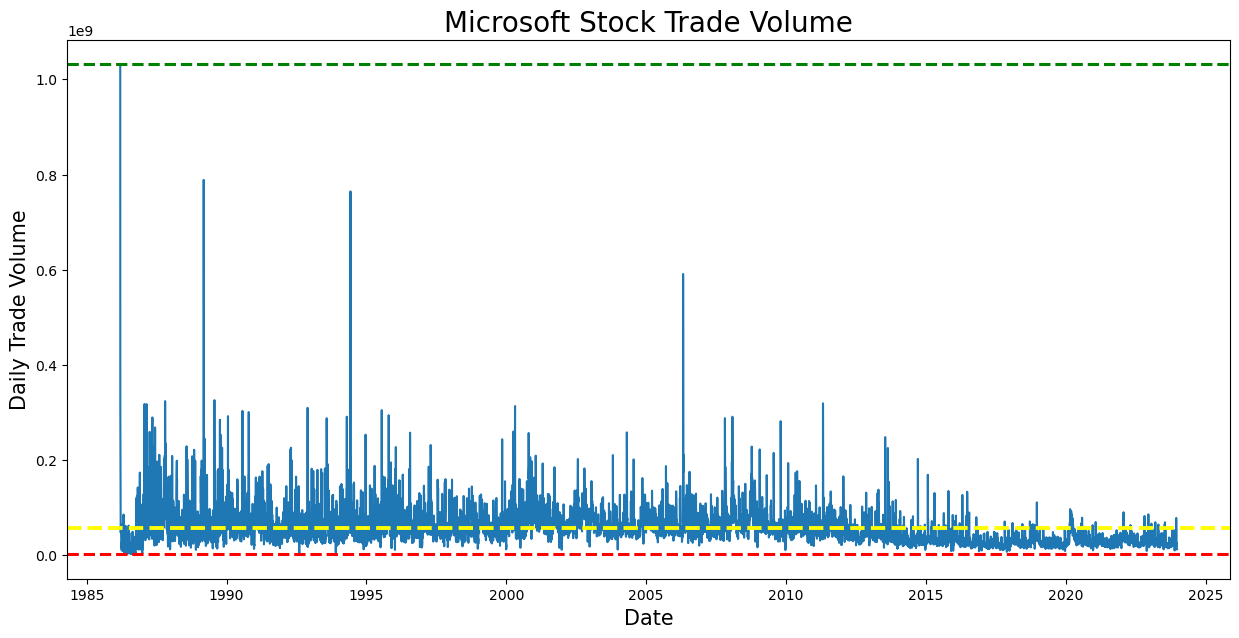

In [189]:
# Microsoft Stock Trade Volume over Five-year Period

ave_x = df.index.mean()
ave_y = df['Volume'].mean()

max_y = df['Volume'].max()

min_y = df['Volume'].min()

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df['Volume'])
ax.set_title(f"Microsoft Stock Trade Volume", fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Daily Trade Volume', fontsize=15)
ax.axhline(y=df['Volume'].max(), linestyle='--', lw=2.2, color='green')
ax.axhline(y=df['Volume'].min(), linestyle='--', lw=2.2, color='red')
ax.axhline(y=df['Volume'].mean(), linestyle='--', lw=2.8, color='yellow')
#ax.axvline(x=df[df['Volume'] == max_y], ls='--', lw='2.2', color='#0aebff')
#ax.annotate(f"Average Trade Volumn {round(df['Volume'].mean(),2)}",
#            xy=(ave_x, ave_y), xytext=(ave_x,ave_y + 1000000),
#            bbox=dict(boxstyle="round", facecolor='#e8e0ba', edgecolor='#d0d5db'))
#ax.annotate(f"Maximum Trade Volumn {round(df['Volume'].max(),2)}",
#            xy=(ave_x, ave_y), xytext=(ave_x,ave_y - 1000000),
#            bbox=dict(boxstyle="round", facecolor='#e8e0ba', edgecolor='#d0d5db'))
#ax.annotate(f"Minimum Trade Volumn {round(df['Volume'].min(),2)}",
#            xy=(ave_x, ave_y), xytext=(ave_x,ave_y - 1000000),
#            bbox=dict(boxstyle="round", facecolor='#e8e0ba', edgecolor='#d0d5db'))

plt.show();

## Testing for Stationarity

In [190]:
# Perform Dickey-Fuller Test

result = adfuller(df['Close'])

print('ADF Statistic: %f' % result[0])
print('P-Value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 4.149616
P-Value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Takeaway

Dickey-Fuller test is a statistical test used to determine the presence of a unit root in a time series data, which is indicative of non-stationarity.

- Test statistic = 1.737136


- P-value = 0.998216

Since P-Value is not less than .05, we fail to reject the null hypothesis. This implies that the time-series dataset is not stationary

## Removing Non-Stationarity

In [191]:
# Differencing to make time series stationary

df['Differenced_Data'] = df['Close'] - df['Close'].shift(1)
df = df.dropna()

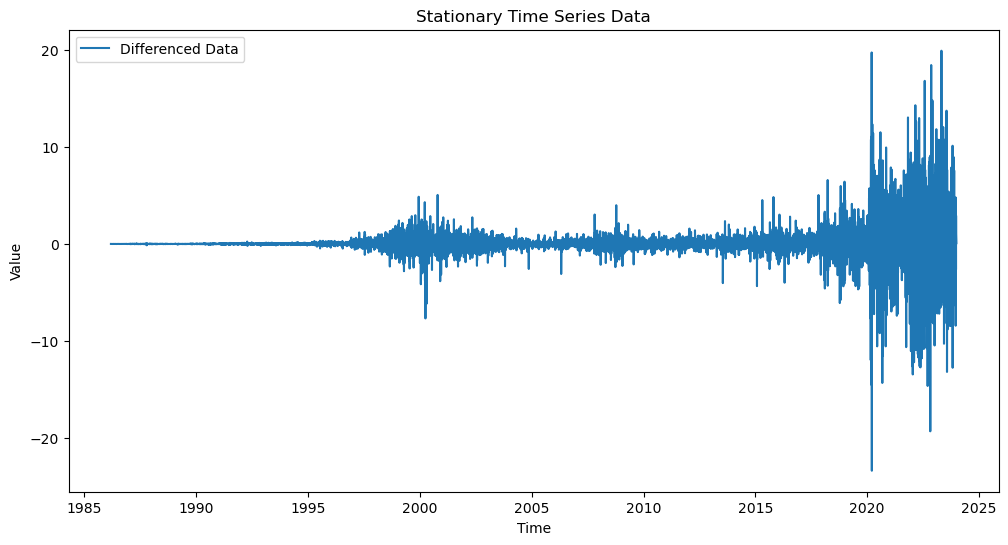

In [192]:
# Visualizing the differenced time series data

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Differenced_Data'], label='Differenced Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Stationary Time Series Data')
plt.legend()

plt.show();

In [193]:
# Performing Dickey-Fuller Test to confirm

adf1 = adfuller(df['Differenced_Data'].dropna())

print('ADF Statistic: %f' % adf1[0])
print('P-Value: %f' % adf1[1])
print('Critical Values:')
for key, value in adf1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.129519
P-Value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Takeaway

- P-Value is now <0.05, which means that it is now stationary.

## ACF and PACF Plots

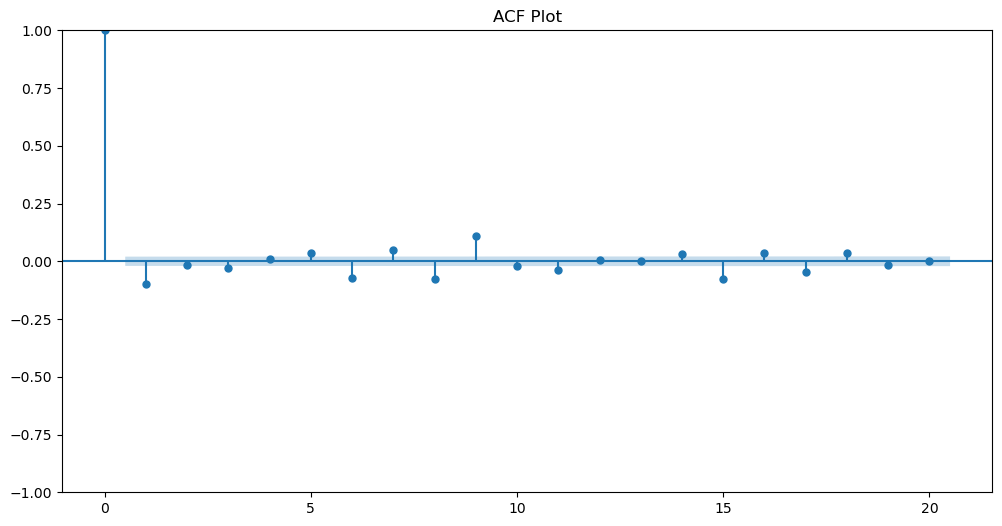

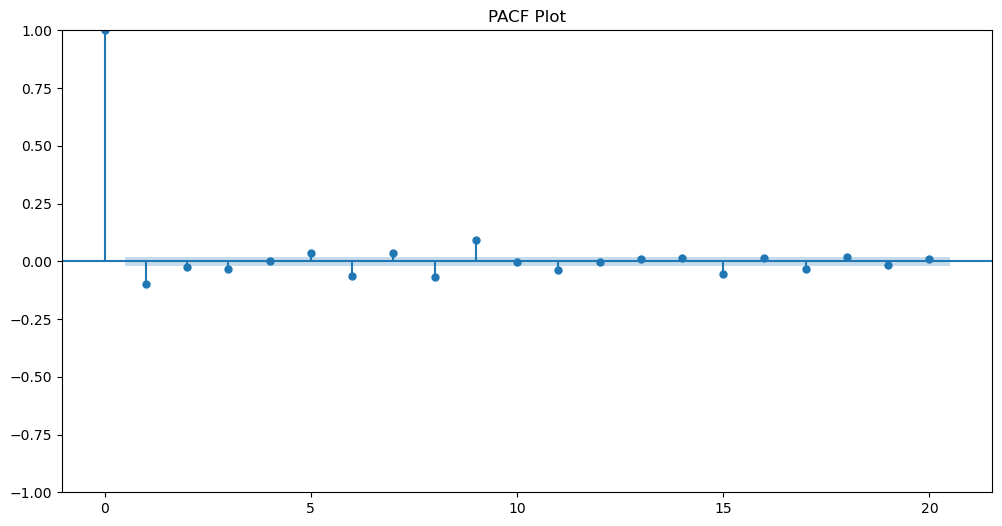

In [194]:
# ACF and PACF plots for determining ARIMA orders

plt.figure(figsize=(12, 6))
plot_acf(df['Differenced_Data'], lags=20, ax=plt.gca())
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Differenced_Data'], lags=20, ax=plt.gca())
plt.title('PACF Plot')
plt.show;

## Data Preprocessing

In [149]:
#y_target = df['']
#X_feat = series_df.index

In [150]:
# Feature Scaling

#sc = MinMaxScaler()
#X_ft = sc.fit_transform(X_feat.values)
#X_ft = pd.DataFrame(columns=X_feat.columns,
#                    data=X_ft,
#                    index=X_feat.index)

## Train Test Split

In [151]:
train_size = int(0.8 * len(df))
train, test = df['Differenced_Data'][:train_size], df['Differenced_Data'][train_size:]

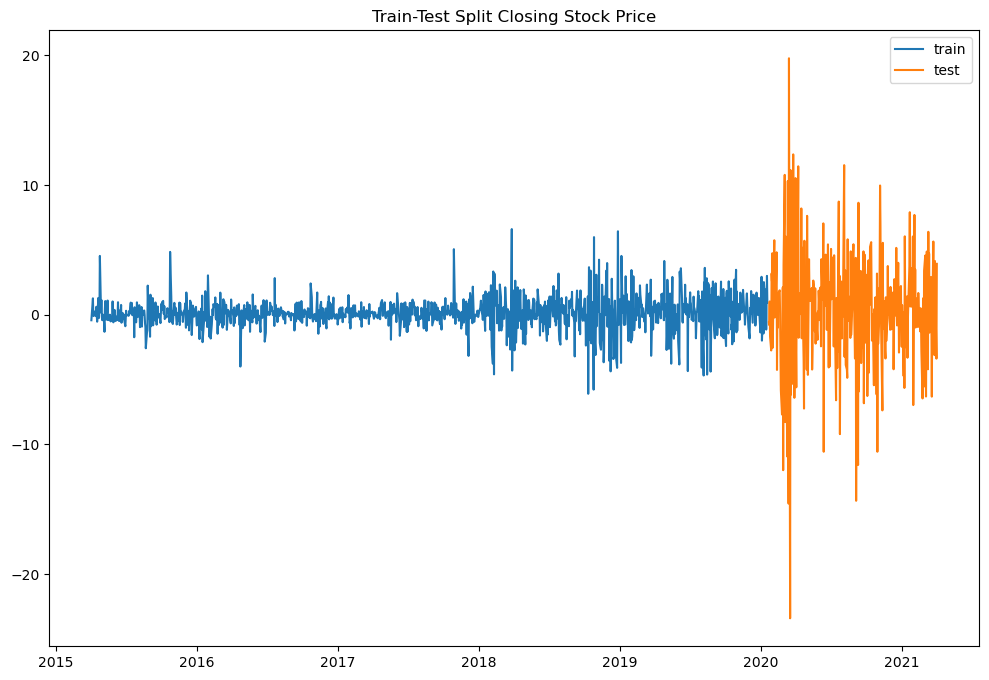

In [152]:


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split Closing Stock Price')
plt.legend();

## Modeling

### Naive

In [153]:
print(train.shape)
print(test.shape)

(1208,)
(302,)


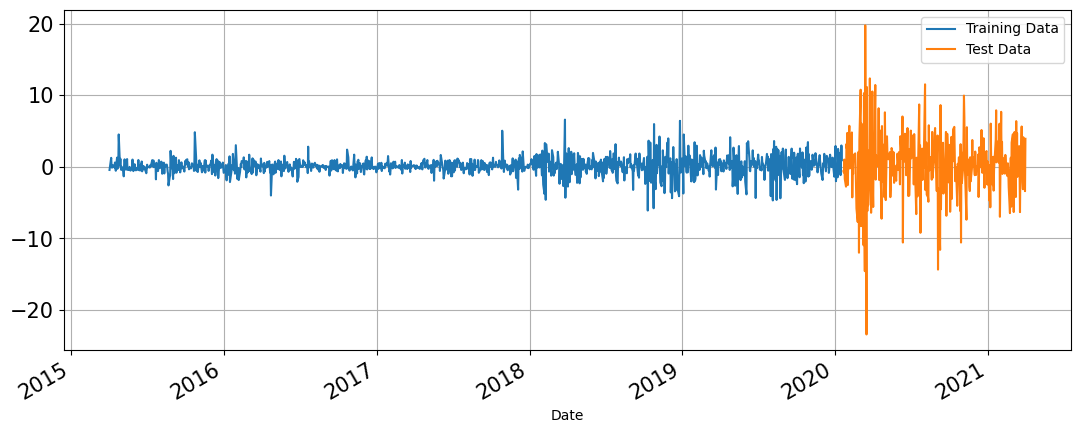

In [45]:
trainC.plot(figsize=(13, 5), fontsize=15)
testC.plot(figsize=(13, 5), fontsize=15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show();

In [46]:
naiveC = trainC.shift(1)
naiveC

Date
2015-04-01 16:00:00     NaN
2015-04-02 16:00:00     NaN
2015-04-06 16:00:00   -0.43
2015-04-07 16:00:00    1.26
2015-04-08 16:00:00   -0.02
                       ... 
2020-01-13 16:00:00   -0.75
2020-01-14 16:00:00    1.94
2020-01-15 16:00:00   -1.15
2020-01-16 16:00:00    1.05
2020-01-17 16:00:00    2.99
Name: Close, Length: 1209, dtype: float64

In [47]:
# RMSE value for naive model

np.sqrt(mean_squared_error(trainC[1:], naiveC.dropna()))

ValueError: Found input variables with inconsistent numbers of samples: [1208, 1207]

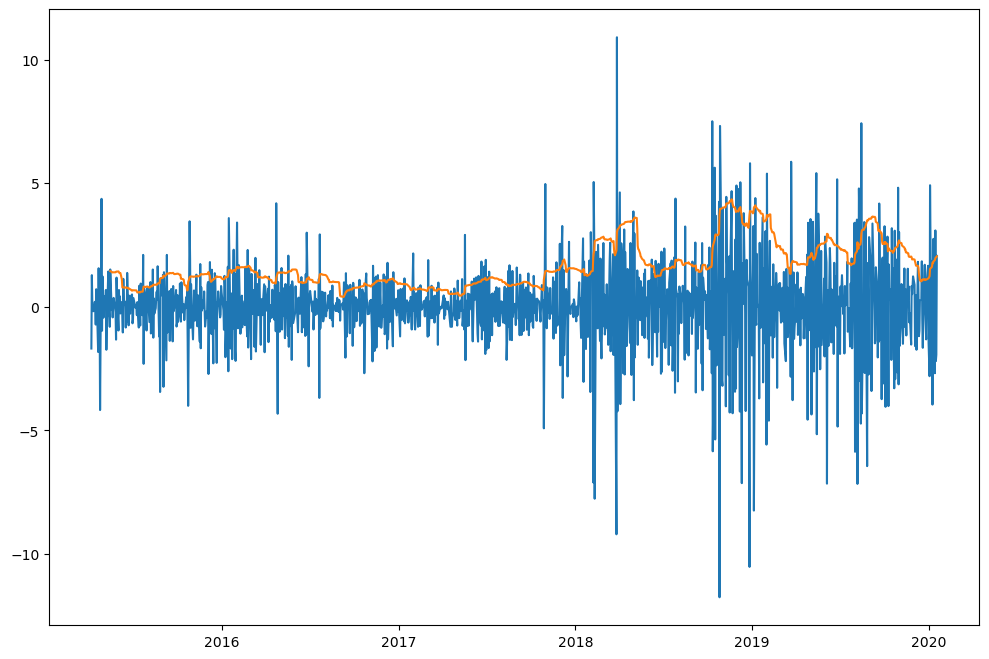

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))

residuals = naiveC[1:] - trainC[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

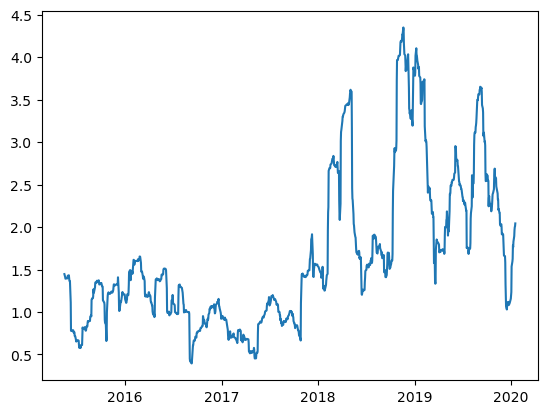

In [49]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).std());

In [50]:
p_val_close = adfuller(trainC.diff()[1:])[1]
print(f"The P-Value associated with the Dickey-Fuller statistical test is {p_val_close},")
if p_val_close < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is not stationary")

MissingDataError: exog contains inf or nans

## ARIMA

In [154]:
# Fit an ARIMA model to the training data

ar_1 = ARIMA(train, order=(1, 1, 1))
ar_1_fit = ar_1.fit()

In [156]:
ar_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Differenced_Data   No. Observations:                 1208
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1968.112
Date:                Wed, 27 Dec 2023   AIC                           3942.224
Time:                        14:59:56   BIC                           3957.512
Sample:                             0   HQIC                          3947.982
                               - 1208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1155      0.019     -6.165      0.000      -0.152      -0.079
ma.L1         -0.9975      0.004   -252.113      0.000      -1.005      -0.990
sigma2         1.5203      0.037     41.322      0.000       1.448       1.592
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               888.07
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
ar_1_fit.aic

3942.2244336182844

In [160]:
# Forecast the test data

arima_forecast = ar_1_fit.forecast(steps=len(test))

In [161]:
# Calculate prediction intervals

arima_residuals = test - arima_forecast
arima_prediction_interval = 1.96 * np.std(arima_residuals)

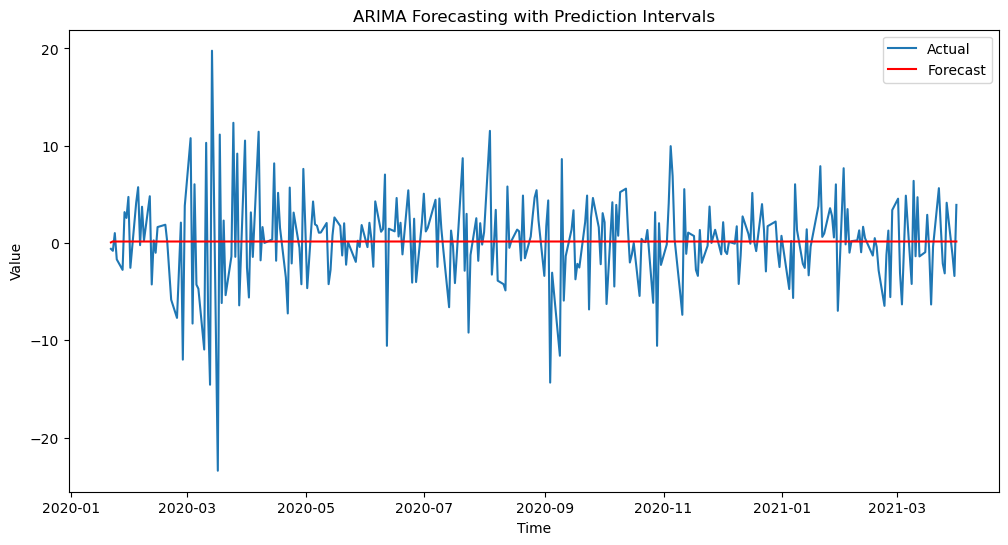

In [162]:
# Plot the forecasts and the actual values with prediction intervals

plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size:], test, label='Actual')
plt.plot(df.index[train_size:], arima_forecast, label='Forecast', color='red')
plt.fill_between(df.index[train_size:], arima_forecast - arima_prediction_interval, arima_forecast + arima_prediction_interval, color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecasting with Prediction Intervals')
plt.legend()

plt.show();

### Random Walk Model

In [54]:
random_walk_model = ARIMA(trainC, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1209
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2464.532
Date:                Wed, 27 Dec 2023   AIC                           4931.065
Time:                        13:34:55   BIC                           4936.162
Sample:                             0   HQIC                          4932.984
                               - 1209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.4311      0.072     47.619      0.000       3.290       3.572
===================================================================================
Ljung-Box (L1) (Q):                 313.09   Jarque-Bera (JB):              1572.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.10   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
random_walk_model.aic

4931.064945799279

In [56]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(trainC, y_hat_ar1))

ValueError: Input contains NaN.

In [57]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(trainC, y_hat_rw))

ValueError: Input contains NaN.

### LSTM Model

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target_Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df
    
# Start day second time around: '2021-03-25'

windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)

windowed_df

## Model Limitation

- Dataset does not include weekends.